# Installation and Repository cloning

In [1]:
!pip install adversarial-robustness-toolbox -U
!pip install advertorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install git+https://github.com/RobustBench/robustbench.git
!pip install matplotlib
!pip install pillow
!pip install foolbox

Looking in indexes: https://download.pytorch.org/whl/cpu
  Cloning https://github.com/RobustBench/robustbench.git to c:\users\d7000ko\appdata\local\temp\pip-req-build-p8focw2i
  Resolved https://github.com/RobustBench/robustbench.git to commit 776bc95bb4167827fb102a32ac5aea62e46cfaab
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached autoattack-0.1-py3-none-any.whl


  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git 'C:\Users\d7000ko\AppData\Local\Temp\pip-req-build-p8focw2i'


## Import Libraries

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

import time
import matplotlib.pyplot as plt
import numpy as np

from art.estimators.classification import PyTorchClassifier
from PIL import Image, ImageDraw, ImageFont, ImageOps
import json
import foolbox as fb

c:\Users\d7000ko\Desktop\Python\elastic_net_adversarial_attack\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and Prepare CIFAR-10 Dataset

In [4]:
def load_dataset(dataset_split):
    # Load CIFAR-10 dataset using torchvision
    transform = transforms.Compose([
      transforms.ToTensor(),
                                 ])
    testset = datasets.CIFAR10(root='./data/cifar', train=False, download=True, transform=transform)

    # Truncated testset for experiments and ablations
    if isinstance(dataset_split, int):
        testset, _ = torch.utils.data.random_split(testset,
                                                          [dataset_split, len(testset) - dataset_split],
                                                          generator=torch.Generator().manual_seed(42))
    
    # Extract data and labels from torchvision dataset
    xtest = torch.stack([data[0] for data in testset])
    ytest = torch.tensor([data[1] for data in testset])

    return xtest, ytest

## Load and Prepare Adversarial Model

In [5]:
from robustbench.utils import load_model

model_name = 'Sehwag2021Proxy_R18'
net = load_model(model_name=model_name, dataset='cifar10', threat_model='L2')
net = torch.nn.DataParallel(net)

net.eval()
net.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Initialize PyTorchClassifier for ART toolbox as a wrapper
art_net = PyTorchClassifier(model=net,
                               loss=criterion,
                               optimizer=optimizer,
                               input_shape=(3, 32, 32),
                               nb_classes=10,
                               device_type=device,
                               clip_values=(0.0, 1.0))
fb_net = fb.PyTorchModel(net, bounds=(0.0, 1.0), device=device)

c:\Users\d7000ko\Desktop\Python\elastic_net_adversarial_attack\.venv\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\d7000ko\Desktop\Python\elastic_net_adversarial_attack\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\d7000ko\Desktop\Python\elastic_net_adversarial_attack\.venv\Lib\site-packages\timm\models\helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\d7000ko\Desktop\Python\elastic_net_adve

## Function to Test Model Accuracy

In [6]:
def test_accuracy(model, xtest, ytest):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for i in range(len(xtest)):
            x = xtest[i].unsqueeze(0).to(device)
            y = ytest[i].unsqueeze(0).to(device)

            outputs = model(x)
            _, predicted = torch.max(outputs, 1)

            total += y.size(0)
            correct += (predicted==y).sum().item()

    accuracy = (correct / total) * 100
    print(f'\nAccuracy of the testset is: {accuracy:.3f}%\n')

## Adversarial Attacks

In [7]:
from art.attacks.evasion import (FastGradientMethod,
                                 ProjectedGradientDescentPyTorch,
                                 AutoProjectedGradientDescent,
                                 AutoAttack,
                                 CarliniL2Method,
                                 DeepFool,
                                 ElasticNet)
from autoattack import AutoAttack as original_AutoAttack

In [ ]:
class AdversarialAttacks:
  def __init__(self, art_net, net, epsilon, eps_iter, norm, max_iterations_fast_attacks, max_iterations_slow_attacks):
    self.art_net = art_net
    self.epsilon = epsilon
    self.eps_iter = eps_iter
    self.norm = norm
    self.max_iterations_fast_attacks = max_iterations_fast_attacks
    self.max_iterations_slow_attacks = max_iterations_slow_attacks
    self.net = net

  def init_attacker(self, attack_type, **kwargs):
    if attack_type=='fast_gradient_method':
        return FastGradientMethod(self.art_net,
                                eps=self.epsilon,
                                eps_step=self.epsilon,
                                norm=self.norm,
                                **kwargs)
    elif attack_type=='projected_gradient_descent':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=self.max_iterations_fast_attacks,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='pgd_early_stopping':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=1,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='ART_AutoAttack':
        return AutoAttack(estimator=self.art_net,
                        eps=self.epsilon,
                        eps_step=self.eps_iter,
                        norm=self.norm)
    elif attack_type=='original_AutoAttack':
        return original_AutoAttack(net, 
                                   norm='L1', 
                                   eps=epsilon,
                                   device=device)
    elif attack_type=='auto_projected_gradient_descent':
        return AutoProjectedGradientDescent(estimator=self.art_net,
                                          eps=self.epsilon,
                                          eps_step=self.eps_iter,
                                          norm=self.norm,
                                          max_iter=self.max_iterations_fast_attacks,
                                          **kwargs)
    elif attack_type=='brendel_bethge':
        return fb.attacks.L1BrendelBethgeAttack(steps=self.max_iterations_fast_attacks)
    elif attack_type=='carlini_wagner_l2':
        return CarliniL2Method(self.art_net,
                               max_iter=self.max_iterations_slow_attacks,
                               **kwargs)
    elif attack_type=='deep_fool':
        return DeepFool(self.art_net,
                      max_iter=self.max_iterations_fast_attacks,
                      epsilon=self.eps_iter,
                      **kwargs)
    elif attack_type=='elastic_net':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks)
    elif attack_type=='elastic_net_L1_rule':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1')
    elif attack_type=='elastic_net_L1_rule_higher_beta':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1',
                      beta=0.01)
    else:
        raise ValueError(f'Attack type "{attack_type}" not supported!')

## Plug-in Function for Adversarial Attack with Early Stopping

In [9]:
def attack_with_early_stopping(art_net, x, y, PGD_iterations, attacker):
    label_flipped = False

    for j in range(PGD_iterations):
        adv_inputs = attacker.generate(x, y.numpy(), verbose=False)

        outputs = art_net.predict(adv_inputs)
        _, predicted = torch.max(torch.tensor(outputs).data, 1)
        label_flipped = bool(predicted.item() != int(y.item()))

        if label_flipped:
            print(f'\tIterations for successful iterative attack: {j+1}')
            break
        
        x = adv_inputs.copy()
            
    return adv_inputs

## Function for Adversarial Distance calculation (attack methods)

In [ ]:
def calculation(art_net, fb_net, net, xtest, ytest, epsilon, eps_iter, norm, max_iterations_slow_attacks, max_iterations_fast_attacks, attack_type, verbose: bool = False):

    distance_list, runtime_list = [], []
    art_net.model.to(device)
    net.to(device)
    
    xtest = xtest.to(device)
    ytest = ytest.to(device)
    
    attacks = AdversarialAttacks(art_net=art_net,
                                 net = net,
                          epsilon=epsilon,
                          eps_iter=eps_iter,
                          norm=norm,
                          max_iterations_fast_attacks=max_iterations_fast_attacks,
                          max_iterations_slow_attacks=max_iterations_slow_attacks)
    attacker = attacks.init_attacker(attack_type)

    robust_predictions = 0

    for i, x in enumerate(xtest):

        x = x.unsqueeze(0)
        y = ytest[i].unsqueeze(0)

        outputs = art_net.predict(x)
        _, clean_predicted = torch.max(torch.tensor(outputs).data, 1)
            
        if int(clean_predicted.item()) != int(y.item()):
            print('Misclassified input. Not attacking.')
            distance_list.append(False)
            runtime_list.append(False)
            continue        

        start_time = time.time()

        if attack_type == 'pgd_early_stopping':
            x_adversarial = attack_with_early_stopping(art_net=art_net,
                                                                x=x.numpy(),
                                                                y=y,
                                                                PGD_iterations=max_iterations_fast_attacks,
                                                                attacker=attacker)
            x_adversarial = torch.from_numpy(x_adversarial)
        elif attack_type == 'brendel_bethge':
            _, x_adversarial, _ = attacker(fb_net, x, y, epsilons=[epsilon])
            x_adversarial = x_adversarial[0]
        elif attack_type == 'original_AutoAttack':
            x_adversarial = attacker.run_standard_evaluation(x, y)
            x_adversarial = x_adversarial
        else:             
            x_adversarial = attacker.generate(x.numpy(), y.numpy())
            x_adversarial = torch.from_numpy(x_adversarial)
        
        end_time = time.time()
        runtime = end_time - start_time
        runtime_list.append(runtime)

        # Adversarial accuracy calculation
        output_adversarial = art_net.predict(x_adversarial)
        _, predicted_adversarial = torch.max(torch.tensor(output_adversarial).data, 1)
        robust_predictions += (predicted_adversarial.item() == int(y.item()))

        # Adversarial distance calculation: if no AE found, save epsilon as distance, otherwise save the distance
        if int(predicted_adversarial.item()) == int(y.item()):
            distance = epsilon
            distance_list.append(distance)
            if verbose:
                print(f'Image {i}: No adversarial example found.')
        else:
            distance = torch.norm((x - x_adversarial), p=float(norm))
            robust_predictions += (round(distance.item(), 2) > epsilon) 
            distance_list.append(min(distance.item(), epsilon)) #appending epsilon if distance of adversarial example is higher

        if verbose:
            print(f'Image {i}\t\tAdversarial_distance: {distance:.5f}\t\tRuntime: {runtime:5f} seconds')
        if (i + 1) % 20 == 0:
            print(f'{i+1} images done. Current Adversarial Accuracy: {robust_predictions/(i+1)}%')

    adversarial_accuracy = (robust_predictions / len(xtest)) * 100
    print(f'\nAdversarial accuracy: {adversarial_accuracy}%\n')

    return distance_list, runtime_list, adversarial_accuracy

## Parameters

In [11]:
norm = 1  # 1, 2, np.inf
max_iterations_fast_attacks = 100
max_iterations_slow_attacks = 20
eps_iter = 0.15
epsilon = 12

## Load the dataset

In [12]:
splitsize = 20      # full, int: splitsize
xtest, ytest = load_dataset(dataset_split=splitsize)

100%|██████████| 170M/170M [00:15<00:00, 10.8MB/s] 


Extracting ./data/cifar\cifar-10-python.tar.gz to ./data/cifar


## Test Accuracy

In [13]:
test_accuracy(net, xtest, ytest)


Accuracy of the testset is: 100.000%



# Experiments

In [ ]:
attack_types = ['fast_gradient_method', #bounded-full
                'projected_gradient_descent', #bounded-full
                'pgd_early_stopping', #not-bounded
                'auto_projected_gradient_descent', #bounded-full
                'deep_fool', #not-bounded
                'brendel_bethge', #bounded-min
                'carlini_wagner_l2', #not-bounded
                'elastic_net', #not-bounded
                'elastic_net_L1_rule', #not-bounded
                'elastic_net_L1_rule_higher_beta', #not-bounded
                #'ART_AutoAttack', #bounded-full
                'original_AutoAttack', #bounded-full
                ]

results_dict = {}

for attack_type in attack_types:
    results_dict[attack_type] = {}
    print(f'\t\t-------------------------- Processing Attack: {attack_type} --------------------------\n')
    results_dict[attack_type]["adversarial_distance"], results_dict[attack_type]["runtime"], results_dict[attack_type]["adversarial_accuracy"] = calculation(
                                                        art_net=art_net,
                                                        fb_net=fb_net,
                                                        net = net,
                                                        xtest=xtest,
                                                        ytest=ytest,
                                                        epsilon=epsilon,
                                                        eps_iter=eps_iter,
                                                        norm=norm,
                                                        max_iterations_fast_attacks=max_iterations_fast_attacks,
                                                        max_iterations_slow_attacks=max_iterations_slow_attacks,
                                                        attack_type=attack_type,
                                                        verbose=True)
    
    mean_value = np.mean([x for x in results_dict[attack_type]["adversarial_distance"] if x is not None])

    print(f'\nMean adversarial distance for {attack_type}: {mean_value:.5f} with total runtime: {sum(results_dict[attack_type]["runtime"]): .5f} seconds\n')

		-------------------------- Processing Attack: fast_gradient_method --------------------------

Image 0: No adversarial example found.
Image 0		Adversarial_distance: 12.00000		Runtime: 0.123829 seconds
Image 1: No adversarial example found.
Image 1		Adversarial_distance: 12.00000		Runtime: 0.038101 seconds
Image 2: No adversarial example found.
Image 2		Adversarial_distance: 12.00000		Runtime: 0.039104 seconds
Image 3: No adversarial example found.
Image 3		Adversarial_distance: 12.00000		Runtime: 0.088736 seconds
Image 4: No adversarial example found.
Image 4		Adversarial_distance: 12.00000		Runtime: 0.112299 seconds
Image 5: No adversarial example found.
Image 5		Adversarial_distance: 12.00000		Runtime: 0.061664 seconds
Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 0.058657 seconds
Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 0.058656 seconds
Image 8: No adversarial example found.
Image 8		Adversa

Image 0: No adversarial example found.
Image 0		Adversarial_distance: 12.00000		Runtime: 3.631663 seconds


Image 1: No adversarial example found.
Image 1		Adversarial_distance: 12.00000		Runtime: 3.657732 seconds


Image 2: No adversarial example found.
Image 2		Adversarial_distance: 12.00000		Runtime: 3.695375 seconds


Image 3: No adversarial example found.
Image 3		Adversarial_distance: 12.00000		Runtime: 3.638180 seconds


Image 4		Adversarial_distance: 1.44216		Runtime: 3.899374 seconds


Image 5: No adversarial example found.
Image 5		Adversarial_distance: 12.00000		Runtime: 3.770030 seconds


Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 3.624143 seconds


Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 3.820672 seconds


Image 8: No adversarial example found.
Image 8		Adversarial_distance: 12.00000		Runtime: 3.851267 seconds


Image 9: No adversarial example found.
Image 9		Adversarial_distance: 12.00000		Runtime: 3.909408 seconds


Image 10: No adversarial example found.
Image 10		Adversarial_distance: 12.00000		Runtime: 4.188142 seconds


Image 11: No adversarial example found.
Image 11		Adversarial_distance: 12.00000		Runtime: 4.207208 seconds


Image 12: No adversarial example found.
Image 12		Adversarial_distance: 12.00000		Runtime: 3.906432 seconds


Image 13: No adversarial example found.
Image 13		Adversarial_distance: 12.00000		Runtime: 4.025729 seconds


Image 14: No adversarial example found.
Image 14		Adversarial_distance: 12.00000		Runtime: 4.060838 seconds


Image 15: No adversarial example found.
Image 15		Adversarial_distance: 12.00000		Runtime: 4.216230 seconds


Image 16		Adversarial_distance: 1.48137		Runtime: 4.608777 seconds


Image 17: No adversarial example found.
Image 17		Adversarial_distance: 12.00000		Runtime: 4.721563 seconds


Image 18: No adversarial example found.
Image 18		Adversarial_distance: 12.00000		Runtime: 4.778746 seconds


Image 19: No adversarial example found.
Image 19		Adversarial_distance: 12.00000		Runtime: 4.557144 seconds
20 images done. Current Adversarial Accuracy: 0.9%

Adversarial accuracy: 90.0%


Mean adversarial distance for projected_gradient_descent: 10.94618 with total runtime:  80.76865 seconds

		-------------------------- Processing Attack: pgd_early_stopping --------------------------



Image 0: No adversarial example found.
Image 0		Adversarial_distance: 12.00000		Runtime: 9.146846 seconds


Image 1: No adversarial example found.
Image 1		Adversarial_distance: 12.00000		Runtime: 9.219028 seconds


Image 2: No adversarial example found.
Image 2		Adversarial_distance: 12.00000		Runtime: 10.877965 seconds


Image 3: No adversarial example found.
Image 3		Adversarial_distance: 12.00000		Runtime: 11.448004 seconds


	Iterations for successful iterative attack: 2
Image 4		Adversarial_distance: 0.30000		Runtime: 0.226101 seconds


Image 5: No adversarial example found.
Image 5		Adversarial_distance: 12.00000		Runtime: 11.380837 seconds


Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 11.479557 seconds


Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 11.422906 seconds


Image 8: No adversarial example found.
Image 8		Adversarial_distance: 12.00000		Runtime: 11.424414 seconds


Image 9: No adversarial example found.
Image 9		Adversarial_distance: 12.00000		Runtime: 10.106462 seconds


Image 10: No adversarial example found.
Image 10		Adversarial_distance: 12.00000		Runtime: 10.039772 seconds


Image 11: No adversarial example found.
Image 11		Adversarial_distance: 12.00000		Runtime: 10.414758 seconds


Image 12: No adversarial example found.
Image 12		Adversarial_distance: 12.00000		Runtime: 10.066321 seconds


Image 13: No adversarial example found.
Image 13		Adversarial_distance: 12.00000		Runtime: 10.406770 seconds


Image 14: No adversarial example found.
Image 14		Adversarial_distance: 12.00000		Runtime: 11.023890 seconds


Image 15: No adversarial example found.
Image 15		Adversarial_distance: 12.00000		Runtime: 12.236569 seconds


	Iterations for successful iterative attack: 5
Image 16		Adversarial_distance: 0.75000		Runtime: 0.577035 seconds


Image 17: No adversarial example found.
Image 17		Adversarial_distance: 12.00000		Runtime: 12.415578 seconds


Image 18: No adversarial example found.
Image 18		Adversarial_distance: 12.00000		Runtime: 12.226113 seconds


Image 19: No adversarial example found.
Image 19		Adversarial_distance: 12.00000		Runtime: 12.815645 seconds
20 images done. Current Adversarial Accuracy: 0.9%

Adversarial accuracy: 90.0%


Mean adversarial distance for pgd_early_stopping: 10.85250 with total runtime:  198.95457 seconds

		-------------------------- Processing Attack: auto_projected_gradient_descent --------------------------



AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:08<00:35,  8.81s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:17<00:26,  8.83s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:26<00:17,  8.65s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:34<00:08,  8.54s/it]




















































AutoPGD - restart: 100%|██████████| 5/5 [00:43<00:00,  8.66s/it]


Image 0: No adversarial example found.
Image 0		Adversarial_distance: 12.00000		Runtime: 43.325867 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:08<00:34,  8.75s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:16<00:24,  8.27s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:25<00:16,  8.42s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:33<00:08,  8.37s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:42<00:00,  8.44s/it]


Image 1: No adversarial example found.
Image 1		Adversarial_distance: 12.00000		Runtime: 42.197562 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:08<00:34,  8.72s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:17<00:25,  8.65s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:26<00:17,  8.78s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:35<00:08,  8.82s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:44<00:00,  8.85s/it]


Image 2: No adversarial example found.
Image 2		Adversarial_distance: 12.00000		Runtime: 44.250687 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]




















































AutoPGD - restart:  20%|██        | 1/5 [00:09<00:38,  9.62s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:18<00:28,  9.44s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:28<00:18,  9.46s/it]





















































AutoPGD - restart:  80%|████████  | 4/5 [00:38<00:09,  9.60s/it]




















































AutoPGD - restart: 100%|██████████| 5/5 [00:47<00:00,  9.57s/it]


Image 3: No adversarial example found.
Image 3		Adversarial_distance: 12.00000		Runtime: 47.845864 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:09<00:37,  9.35s/it]


Image 4		Adversarial_distance: 12.00000		Runtime: 9.350916 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:08<00:35,  8.81s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:17<00:26,  8.69s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:26<00:17,  8.75s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:35<00:08,  8.89s/it]
























































AutoPGD - restart: 100%|██████████| 5/5 [00:45<00:00,  9.06s/it]


Image 5: No adversarial example found.
Image 5		Adversarial_distance: 12.00000		Runtime: 45.284346 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]























































AutoPGD - restart:  20%|██        | 1/5 [00:09<00:38,  9.67s/it]




















































AutoPGD - restart:  40%|████      | 2/5 [00:17<00:25,  8.37s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:24<00:15,  7.75s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:31<00:07,  7.48s/it]




















































AutoPGD - restart: 100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 39.987959 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:06<00:25,  6.48s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:12<00:18,  6.20s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:18<00:12,  6.18s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:24<00:06,  6.05s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:30<00:00,  6.18s/it]


Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 30.915443 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:05<00:23,  5.99s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:11<00:17,  5.89s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:17<00:11,  5.81s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:23<00:05,  5.83s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:29<00:00,  5.87s/it]


Image 8: No adversarial example found.
Image 8		Adversarial_distance: 12.00000		Runtime: 29.336111 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:06<00:24,  6.21s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:12<00:18,  6.20s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:18<00:12,  6.35s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:24<00:06,  6.15s/it]


















































AutoPGD - restart: 100%|██████████| 5/5 [00:30<00:00,  6.07s/it]


Image 9: No adversarial example found.
Image 9		Adversarial_distance: 12.00000		Runtime: 30.344330 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]


















































AutoPGD - restart:  20%|██        | 1/5 [00:05<00:23,  5.81s/it]

















































AutoPGD - restart:  40%|████      | 2/5 [00:11<00:16,  5.65s/it]


















































AutoPGD - restart:  60%|██████    | 3/5 [00:16<00:11,  5.54s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:22<00:05,  5.59s/it]


















































AutoPGD - restart: 100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


Image 10: No adversarial example found.
Image 10		Adversarial_distance: 12.00000		Runtime: 28.045575 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

















































AutoPGD - restart:  20%|██        | 1/5 [00:05<00:22,  5.65s/it]


















































AutoPGD - restart:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]

















































AutoPGD - restart:  60%|██████    | 3/5 [00:16<00:11,  5.58s/it]

















































AutoPGD - restart:  80%|████████  | 4/5 [00:22<00:05,  5.54s/it]


















































AutoPGD - restart: 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]


Image 11: No adversarial example found.
Image 11		Adversarial_distance: 12.00000		Runtime: 27.693105 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:05<00:22,  5.71s/it]

















































AutoPGD - restart:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]

















































AutoPGD - restart:  60%|██████    | 3/5 [00:16<00:11,  5.51s/it]


















































AutoPGD - restart:  80%|████████  | 4/5 [00:22<00:05,  5.49s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:27<00:00,  5.53s/it]


Image 12: No adversarial example found.
Image 12		Adversarial_distance: 12.00000		Runtime: 27.651213 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:05<00:22,  5.63s/it]

















































AutoPGD - restart:  40%|████      | 2/5 [00:11<00:17,  5.75s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:17<00:12,  6.06s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:23<00:06,  6.01s/it]

















































AutoPGD - restart: 100%|██████████| 5/5 [00:29<00:00,  5.94s/it]


Image 13: No adversarial example found.
Image 13		Adversarial_distance: 12.00000		Runtime: 29.715255 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]


















































AutoPGD - restart:  20%|██        | 1/5 [00:06<00:24,  6.15s/it]


















































AutoPGD - restart:  40%|████      | 2/5 [00:12<00:19,  6.50s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:20<00:13,  6.81s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:27<00:06,  6.94s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:34<00:00,  6.89s/it]


Image 14: No adversarial example found.
Image 14		Adversarial_distance: 12.00000		Runtime: 34.472778 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:07<00:29,  7.29s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:14<00:22,  7.48s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:22<00:15,  7.57s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:29<00:07,  7.42s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:36<00:00,  7.33s/it]


Image 15: No adversarial example found.
Image 15		Adversarial_distance: 12.00000		Runtime: 36.633640 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:05<00:23,  5.99s/it]


Image 16		Adversarial_distance: 12.00002		Runtime: 5.989501 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:06<00:26,  6.54s/it]



















































AutoPGD - restart:  40%|████      | 2/5 [00:12<00:19,  6.34s/it]



















































AutoPGD - restart:  60%|██████    | 3/5 [00:18<00:12,  6.25s/it]



















































AutoPGD - restart:  80%|████████  | 4/5 [00:25<00:06,  6.38s/it]



















































AutoPGD - restart: 100%|██████████| 5/5 [00:32<00:00,  6.44s/it]


Image 17: No adversarial example found.
Image 17		Adversarial_distance: 12.00000		Runtime: 32.210526 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]



















































AutoPGD - restart:  20%|██        | 1/5 [00:05<00:22,  5.62s/it]

















































AutoPGD - restart:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]


















































AutoPGD - restart:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]


















































AutoPGD - restart:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]

















































AutoPGD - restart: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]


Image 18: No adversarial example found.
Image 18		Adversarial_distance: 12.00000		Runtime: 26.443356 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]


















































AutoPGD - restart:  20%|██        | 1/5 [00:05<00:21,  5.45s/it]

















































AutoPGD - restart:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]


















































AutoPGD - restart:  60%|██████    | 3/5 [00:15<00:10,  5.25s/it]

















































AutoPGD - restart:  80%|████████  | 4/5 [00:21<00:05,  5.25s/it]


















































AutoPGD - restart: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]


Image 19: No adversarial example found.
Image 19		Adversarial_distance: 12.00000		Runtime: 26.318151 seconds
20 images done. Current Adversarial Accuracy: 0.9%

Adversarial accuracy: 90.0%


Mean adversarial distance for auto_projected_gradient_descent: 12.00000 with total runtime:  638.01218 seconds

		-------------------------- Processing Attack: deep_fool --------------------------



DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Image 0		Adversarial_distance: 27.27559		Runtime: 0.980106 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Image 1		Adversarial_distance: 151.03329		Runtime: 0.646719 seconds


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Image 2		Adversarial_distance: 77.76517		Runtime: 1.344074 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Image 3		Adversarial_distance: 26.41821		Runtime: 0.952541 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Image 4		Adversarial_distance: 0.96864		Runtime: 0.955041 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Image 5		Adversarial_distance: 24.11443		Runtime: 0.973089 seconds


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Image 6		Adversarial_distance: 70.43808		Runtime: 1.603767 seconds


DeepFool: 100%|██████████| 1/1 [00:31<00:00, 31.46s/it]


Image 7		Adversarial_distance: 63.85555		Runtime: 31.473757 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Image 8		Adversarial_distance: 21.81308		Runtime: 0.670282 seconds


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Image 9		Adversarial_distance: 17.39570		Runtime: 1.600258 seconds


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Image 10		Adversarial_distance: 241.95067		Runtime: 2.850117 seconds


DeepFool: 100%|██████████| 1/1 [00:31<00:00, 31.70s/it]


Image 11		Adversarial_distance: 39.08981		Runtime: 31.718982 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Image 12		Adversarial_distance: 35.73832		Runtime: 0.960556 seconds


DeepFool: 100%|██████████| 1/1 [00:31<00:00, 31.43s/it]


Image 13		Adversarial_distance: 23.09571		Runtime: 31.439259 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Image 14		Adversarial_distance: 21.79620		Runtime: 0.995148 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Image 15		Adversarial_distance: 38.68197		Runtime: 0.648725 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Image 16		Adversarial_distance: 2.41387		Runtime: 0.965067 seconds


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


Image 17		Adversarial_distance: 332.37314		Runtime: 3.191491 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Image 18		Adversarial_distance: 27.71595		Runtime: 0.965068 seconds


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Image 19		Adversarial_distance: 139.02325		Runtime: 0.962059 seconds
20 images done. Current Adversarial Accuracy: 0.9%

Adversarial accuracy: 90.0%


Mean adversarial distance for deep_fool: 10.96913 with total runtime:  115.89611 seconds

		-------------------------- Processing Attack: brendel_bethge --------------------------



c:\Users\d7000ko\Desktop\Python\elastic_net_adversarial_attack\.venv\Lib\site-packages\eagerpy\tensor\pytorch.py:263: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  return type(self)(torch.as_tensor(a, device=self.raw.device))


Image 0		Adversarial_distance: 3.15941		Runtime: 56.645075 seconds
Image 1		Adversarial_distance: 10.70916		Runtime: 8.816778 seconds
Image 2		Adversarial_distance: 10.60866		Runtime: 8.323201 seconds
Image 3		Adversarial_distance: 5.41523		Runtime: 7.795269 seconds
Image 4		Adversarial_distance: 0.18977		Runtime: 5.875150 seconds
Image 5		Adversarial_distance: 5.82565		Runtime: 10.811337 seconds
Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 9.034103 seconds
Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 8.862008 seconds
Image 8		Adversarial_distance: 6.12696		Runtime: 8.468571 seconds
Image 9		Adversarial_distance: 2.75087		Runtime: 7.279425 seconds
Image 10: No adversarial example found.
Image 10		Adversarial_distance: 12.00000		Runtime: 9.121827 seconds
Image 11		Adversarial_distance: 10.97889		Runtime: 6.614614 seconds
Image 12		Adversarial_distance: 10.29469		Runtime: 13.678013 seconds
Image 13		A

C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.68s/it]


Image 0		Adversarial_distance: 21.36541		Runtime: 23.702331 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.53s/it]


Image 1		Adversarial_distance: 42.79327		Runtime: 23.554813 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.43s/it]


Image 2		Adversarial_distance: 50.61301		Runtime: 23.452509 seconds


C&W L_2: 100%|██████████| 1/1 [00:22<00:00, 22.94s/it]


Image 3		Adversarial_distance: 22.53440		Runtime: 22.967577 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.54s/it]


Image 4		Adversarial_distance: 1.00345		Runtime: 23.573294 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.07s/it]


Image 5		Adversarial_distance: 27.82006		Runtime: 23.092631 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.13s/it]


Image 6		Adversarial_distance: 38.78922		Runtime: 23.154225 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.04s/it]


Image 7		Adversarial_distance: 45.48317		Runtime: 23.071532 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.19s/it]


Image 8		Adversarial_distance: 19.59687		Runtime: 23.218812 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.69s/it]


Image 9		Adversarial_distance: 14.44174		Runtime: 23.712221 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.14s/it]


Image 10		Adversarial_distance: 92.69496		Runtime: 23.212931 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.29s/it]


Image 11		Adversarial_distance: 29.59852		Runtime: 23.317675 seconds


C&W L_2: 100%|██████████| 1/1 [00:23<00:00, 23.15s/it]


Image 12		Adversarial_distance: 28.83188		Runtime: 23.184790 seconds


C&W L_2: 100%|██████████| 1/1 [00:27<00:00, 27.28s/it]


Image 13		Adversarial_distance: 17.99397		Runtime: 27.316600 seconds


C&W L_2: 100%|██████████| 1/1 [00:25<00:00, 25.26s/it]


Image 14		Adversarial_distance: 16.76785		Runtime: 25.290378 seconds


C&W L_2: 100%|██████████| 1/1 [00:25<00:00, 25.91s/it]


Image 15		Adversarial_distance: 28.24701		Runtime: 25.937311 seconds


C&W L_2: 100%|██████████| 1/1 [00:26<00:00, 26.35s/it]


Image 16		Adversarial_distance: 2.00003		Runtime: 26.387542 seconds


C&W L_2: 100%|██████████| 1/1 [00:25<00:00, 25.66s/it]


Image 17		Adversarial_distance: 125.80502		Runtime: 25.691421 seconds


C&W L_2: 100%|██████████| 1/1 [00:25<00:00, 25.31s/it]


Image 18		Adversarial_distance: 22.40048		Runtime: 25.385056 seconds


C&W L_2: 100%|██████████| 1/1 [00:26<00:00, 26.79s/it]


Image 19		Adversarial_distance: 97.53387		Runtime: 26.816458 seconds
20 images done. Current Adversarial Accuracy: 0.9%

Adversarial accuracy: 90.0%


Mean adversarial distance for carlini_wagner_l2: 10.95017 with total runtime:  486.04010 seconds

		-------------------------- Processing Attack: elastic_net --------------------------



EAD: 100%|██████████| 1/1 [00:19<00:00, 19.04s/it]


Image 0		Adversarial_distance: 18.76389		Runtime: 19.067756 seconds


EAD: 100%|██████████| 1/1 [00:23<00:00, 23.41s/it]


Image 1		Adversarial_distance: 45.83060		Runtime: 23.434688 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.50s/it]


Image 2		Adversarial_distance: 40.43785		Runtime: 18.530358 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.08s/it]


Image 3		Adversarial_distance: 16.51512		Runtime: 18.106343 seconds


EAD: 100%|██████████| 1/1 [00:19<00:00, 19.94s/it]


Image 4		Adversarial_distance: 0.40151		Runtime: 19.967080 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.17s/it]


Image 5		Adversarial_distance: 24.05669		Runtime: 18.200808 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.83s/it]


Image 6		Adversarial_distance: 30.78548		Runtime: 18.860846 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.49s/it]


Image 7		Adversarial_distance: 42.99094		Runtime: 18.518276 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.85s/it]


Image 8		Adversarial_distance: 12.68716		Runtime: 18.889468 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.26s/it]


Image 9		Adversarial_distance: 9.79083		Runtime: 20.297630 seconds


EAD: 100%|██████████| 1/1 [00:19<00:00, 19.79s/it]


Image 10		Adversarial_distance: 116.42798		Runtime: 19.826439 seconds


EAD: 100%|██████████| 1/1 [00:21<00:00, 21.84s/it]


Image 11		Adversarial_distance: 22.99075		Runtime: 21.925371 seconds


EAD: 100%|██████████| 1/1 [00:19<00:00, 19.11s/it]


Image 12		Adversarial_distance: 26.20331		Runtime: 19.133982 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.07s/it]


Image 13		Adversarial_distance: 14.90452		Runtime: 18.098215 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.41s/it]


Image 14		Adversarial_distance: 9.51932		Runtime: 18.439621 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.40s/it]


Image 15		Adversarial_distance: 21.42607		Runtime: 18.432807 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.53s/it]


Image 16		Adversarial_distance: 1.09580		Runtime: 18.560328 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.54s/it]


Image 17		Adversarial_distance: 84.19077		Runtime: 18.569454 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.25s/it]


Image 18		Adversarial_distance: 18.16517		Runtime: 18.273127 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.31s/it]


Image 19		Adversarial_distance: 77.94397		Runtime: 18.344358 seconds
20 images done. Current Adversarial Accuracy: 0.8%

Adversarial accuracy: 80.0%


Mean adversarial distance for elastic_net: 10.64037 with total runtime:  383.47696 seconds

		-------------------------- Processing Attack: elastic_net_L1_rule --------------------------



EAD: 100%|██████████| 1/1 [00:18<00:00, 18.10s/it]


Image 0		Adversarial_distance: 12.32277		Runtime: 18.129294 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.09s/it]


Image 1		Adversarial_distance: 25.71477		Runtime: 18.127287 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.55s/it]


Image 2		Adversarial_distance: 26.58664		Runtime: 18.580961 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.16s/it]


Image 3		Adversarial_distance: 9.50406		Runtime: 18.193112 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.18s/it]


Image 4		Adversarial_distance: 0.22229		Runtime: 18.205462 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.05s/it]


Image 5		Adversarial_distance: 15.47752		Runtime: 18.078132 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.58s/it]


Image 6		Adversarial_distance: 25.54886		Runtime: 18.612240 seconds


EAD: 100%|██████████| 1/1 [00:19<00:00, 19.55s/it]


Image 7		Adversarial_distance: 28.83078		Runtime: 19.591212 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.98s/it]


Image 8		Adversarial_distance: 8.22325		Runtime: 19.074719 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.87s/it]


Image 9		Adversarial_distance: 4.22993		Runtime: 18.898939 seconds


EAD: 100%|██████████| 1/1 [00:19<00:00, 19.45s/it]


Image 10		Adversarial_distance: 116.42798		Runtime: 19.486194 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.63s/it]


Image 11		Adversarial_distance: 15.97907		Runtime: 20.663980 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.04s/it]


Image 12		Adversarial_distance: 16.18803		Runtime: 18.093361 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.63s/it]


Image 13		Adversarial_distance: 9.88260		Runtime: 18.666245 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.11s/it]


Image 14		Adversarial_distance: 7.29711		Runtime: 18.139313 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.54s/it]


Image 15		Adversarial_distance: 14.88561		Runtime: 18.575005 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.58s/it]


Image 16		Adversarial_distance: 0.74611		Runtime: 18.611056 seconds


EAD: 100%|██████████| 1/1 [00:18<00:00, 18.12s/it]


Image 17		Adversarial_distance: 84.19077		Runtime: 18.154268 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.25s/it]


Image 18		Adversarial_distance: 11.21024		Runtime: 20.275575 seconds


EAD: 100%|██████████| 1/1 [00:20<00:00, 20.75s/it]


Image 19		Adversarial_distance: 71.52669		Runtime: 20.779042 seconds
20 images done. Current Adversarial Accuracy: 0.6%

Adversarial accuracy: 60.0%


Mean adversarial distance for elastic_net_L1_rule: 9.76578 with total runtime:  376.93540 seconds

		-------------------------- Processing Attack: elastic_net_L1_only --------------------------



EAD: 100%|██████████| 1/1 [00:19<00:00, 19.36s/it]


Image 0		Adversarial_distance: 22.61623		Runtime: 19.382621 seconds


EAD: 100%|██████████| 1/1 [00:19<00:00, 19.04s/it]


Image 1		Adversarial_distance: 49.41926		Runtime: 19.063779 seconds


EAD: 100%|██████████| 1/1 [00:24<00:00, 24.98s/it]


Image 2		Adversarial_distance: 52.21043		Runtime: 25.021409 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.25s/it]


Image 3		Adversarial_distance: 22.58830		Runtime: 17.271991 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.07s/it]


Image 4		Adversarial_distance: 0.84249		Runtime: 17.089986 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.08s/it]


Image 5		Adversarial_distance: 29.90839		Runtime: 17.106045 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.10s/it]


Image 6		Adversarial_distance: 45.80159		Runtime: 17.124062 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.04s/it]


Image 7		Adversarial_distance: 49.64213		Runtime: 17.058889 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.12s/it]


Image 8		Adversarial_distance: 17.49305		Runtime: 17.147641 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.31s/it]


Image 9		Adversarial_distance: 15.35784		Runtime: 17.332007 seconds


EAD: 100%|██████████| 1/1 [00:16<00:00, 16.95s/it]


Image 10		Adversarial_distance: 154.58829		Runtime: 16.971181 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.03s/it]


Image 11		Adversarial_distance: 32.10957		Runtime: 17.059882 seconds


EAD: 100%|██████████| 1/1 [00:16<00:00, 16.96s/it]


Image 12		Adversarial_distance: 29.98403		Runtime: 16.985727 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.08s/it]


Image 13		Adversarial_distance: 19.13931		Runtime: 17.101509 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.10s/it]


Image 14		Adversarial_distance: 18.22507		Runtime: 17.125566 seconds


EAD: 100%|██████████| 1/1 [00:16<00:00, 16.95s/it]


Image 15		Adversarial_distance: 28.38509		Runtime: 16.975741 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.22s/it]


Image 16		Adversarial_distance: 2.09560		Runtime: 17.246898 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.11s/it]


Image 17		Adversarial_distance: 117.84857		Runtime: 17.129582 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.43s/it]


Image 18		Adversarial_distance: 22.85289		Runtime: 17.452573 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.10s/it]


Image 19		Adversarial_distance: 104.74531		Runtime: 17.126141 seconds
20 images done. Current Adversarial Accuracy: 0.9%

Adversarial accuracy: 90.0%


Mean adversarial distance for elastic_net_L1_only: 10.94690 with total runtime:  354.77323 seconds

		-------------------------- Processing Attack: elastic_net_L1_rule_higher_beta --------------------------



EAD: 100%|██████████| 1/1 [00:17<00:00, 17.12s/it]


Image 0		Adversarial_distance: 5.62669		Runtime: 17.149821 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.12s/it]


Image 1		Adversarial_distance: 12.40326		Runtime: 17.145199 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.09s/it]


Image 2		Adversarial_distance: 16.40340		Runtime: 17.117042 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.16s/it]


Image 3		Adversarial_distance: 6.57785		Runtime: 17.189213 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.24s/it]


Image 4		Adversarial_distance: 0.19646		Runtime: 17.264436 seconds


EAD: 100%|██████████| 1/1 [00:16<00:00, 16.98s/it]


Image 5		Adversarial_distance: 9.75566		Runtime: 17.007753 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.01s/it]


Image 6		Adversarial_distance: 19.81031		Runtime: 17.034849 seconds


EAD: 100%|██████████| 1/1 [00:16<00:00, 16.96s/it]


Image 7		Adversarial_distance: 21.18801		Runtime: 16.980185 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.29s/it]


Image 8		Adversarial_distance: 4.26372		Runtime: 17.315131 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.09s/it]


Image 9		Adversarial_distance: 2.98310		Runtime: 17.115052 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.02s/it]


Image 10		Adversarial_distance: 59.58961		Runtime: 17.047764 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.11s/it]


Image 11		Adversarial_distance: 11.48692		Runtime: 17.132088 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.05s/it]


Image 12		Adversarial_distance: 14.62532		Runtime: 17.074931 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.33s/it]


Image 13		Adversarial_distance: 7.60948		Runtime: 17.356332 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.47s/it]


Image 14		Adversarial_distance: 5.33341		Runtime: 17.501317 seconds


EAD: 100%|██████████| 1/1 [00:16<00:00, 16.96s/it]


Image 15		Adversarial_distance: 12.04762		Runtime: 16.988215 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.07s/it]


Image 16		Adversarial_distance: 0.67042		Runtime: 17.095540 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.11s/it]


Image 17		Adversarial_distance: 55.30837		Runtime: 17.131659 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.02s/it]


Image 18		Adversarial_distance: 7.34123		Runtime: 17.044374 seconds


EAD: 100%|██████████| 1/1 [00:17<00:00, 17.06s/it]


Image 19		Adversarial_distance: 42.61931		Runtime: 17.090495 seconds
20 images done. Current Adversarial Accuracy: 0.45%

Adversarial accuracy: 45.0%


Mean adversarial distance for elastic_net_L1_rule_higher_beta: 8.49225 with total runtime:  342.78140 seconds

		-------------------------- Processing Attack: original_AutoAttack --------------------------

setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 100.00%
apgd-ce - 1/1 - 1 out of 1 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 2.9 s)
max L1 perturbation: 12.00000, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%
Image 0		Adversarial_distance: 12.00000		Runtime: 2.958370 seconds
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 100.00%
apgd-ce - 1/1 - 1 out of 1 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 2.9 s)
max L1 perturbation: 12.00000, nan in ten

## Save Results to JSON File

In [15]:
json_file_path = f'./data/attack_comparison_{model_name}_L{norm}.json'

with open(json_file_path, 'w') as f:
    json.dump(results_dict, f, indent=4)
print(f'Evaluation results are saved under "{json_file_path}".')

Evaluation results are saved under "./data/attack_comparison_Sehwag2021Proxy_R18_L1.json".


# Plotting

## Distances

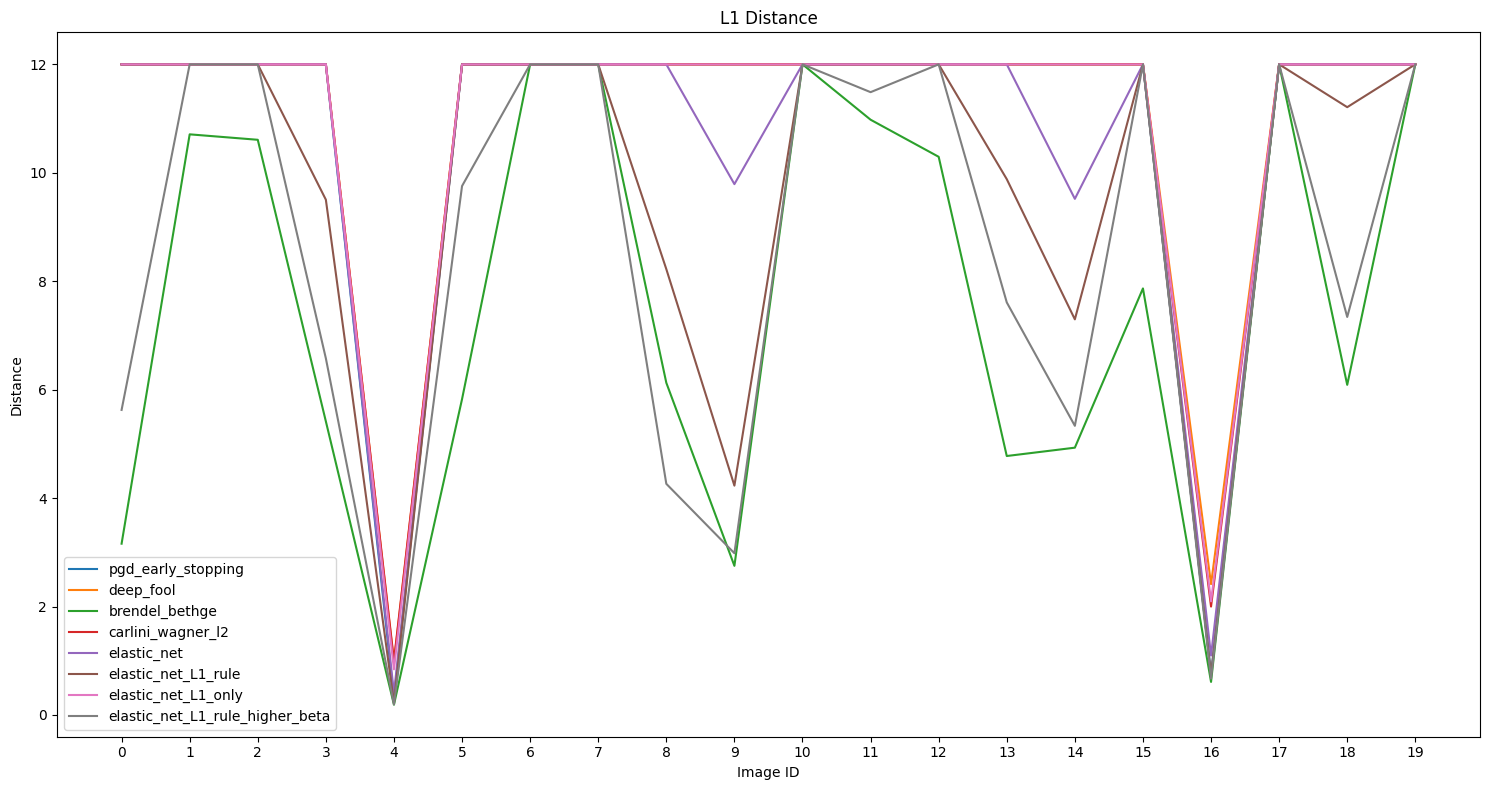

In [ ]:
attack_types_with_distance = [
                'brendel_bethge', #bounded-min
                'pgd_early_stopping', #not-bounded
                'deep_fool', #not-bounded
                'carlini_wagner_l2', #not-bounded
                'elastic_net', #not-bounded
                'elastic_net_L1_rule', #not-bounded
                'elastic_net_L1_rule_higher_beta', #not-bounded
                ]

selected_attack_types_with_distance = [a for a in attack_types if a in attack_types_with_distance]

plt.figure(figsize=(15, 8))
for attack_type in selected_attack_types_with_distance:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['adversarial_distance'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Distance')
plt.title(f'L{norm} Distance')
plt.legend()
plt.tight_layout()
plt.xticks(list(range(len(xtest))))
plt.show()

# Runtime per image

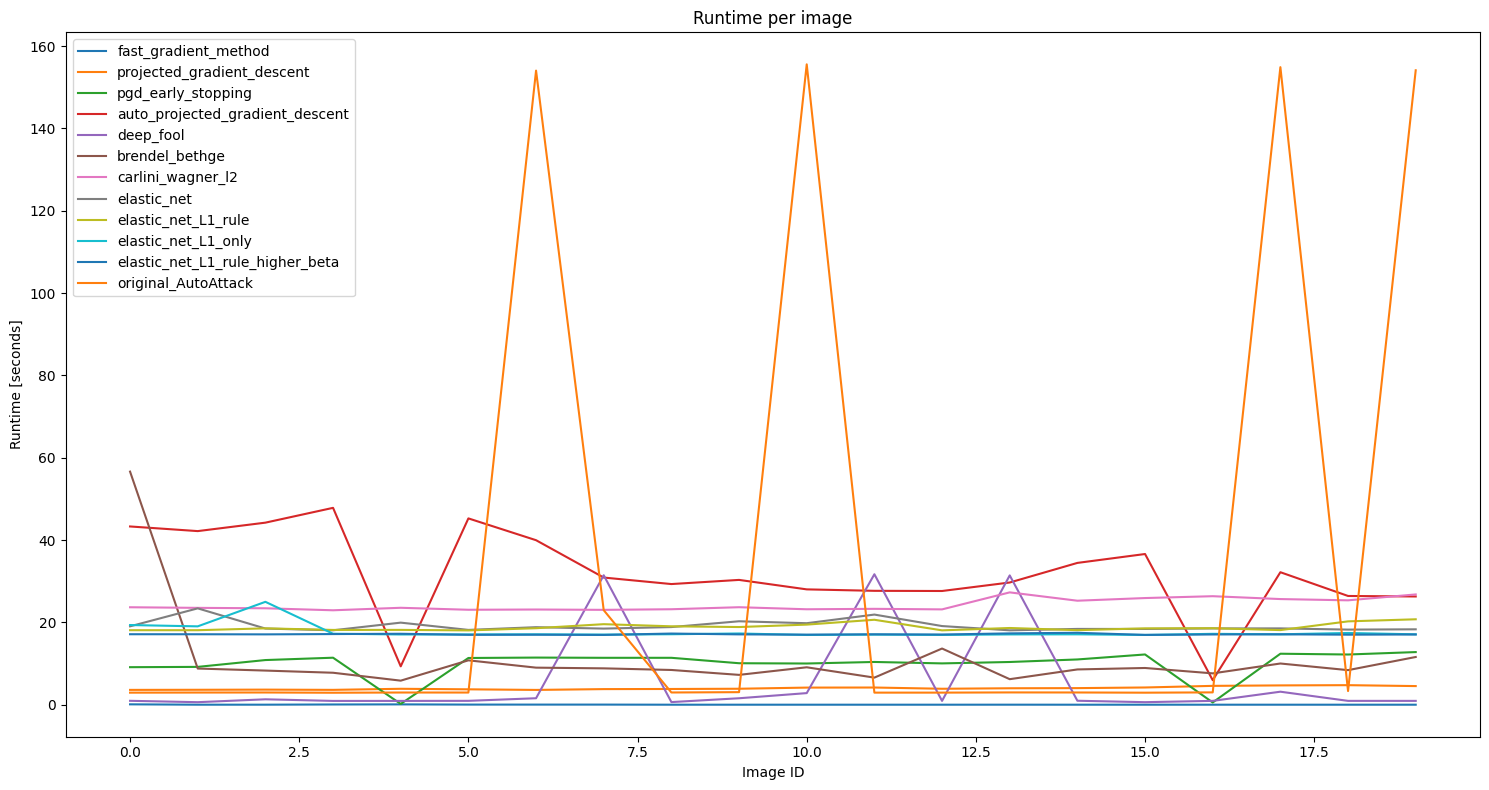

In [17]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['runtime'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Runtime [seconds]')
plt.title('Runtime per image')
plt.legend()
plt.tight_layout()
plt.show()

## Adversarial Accuracy

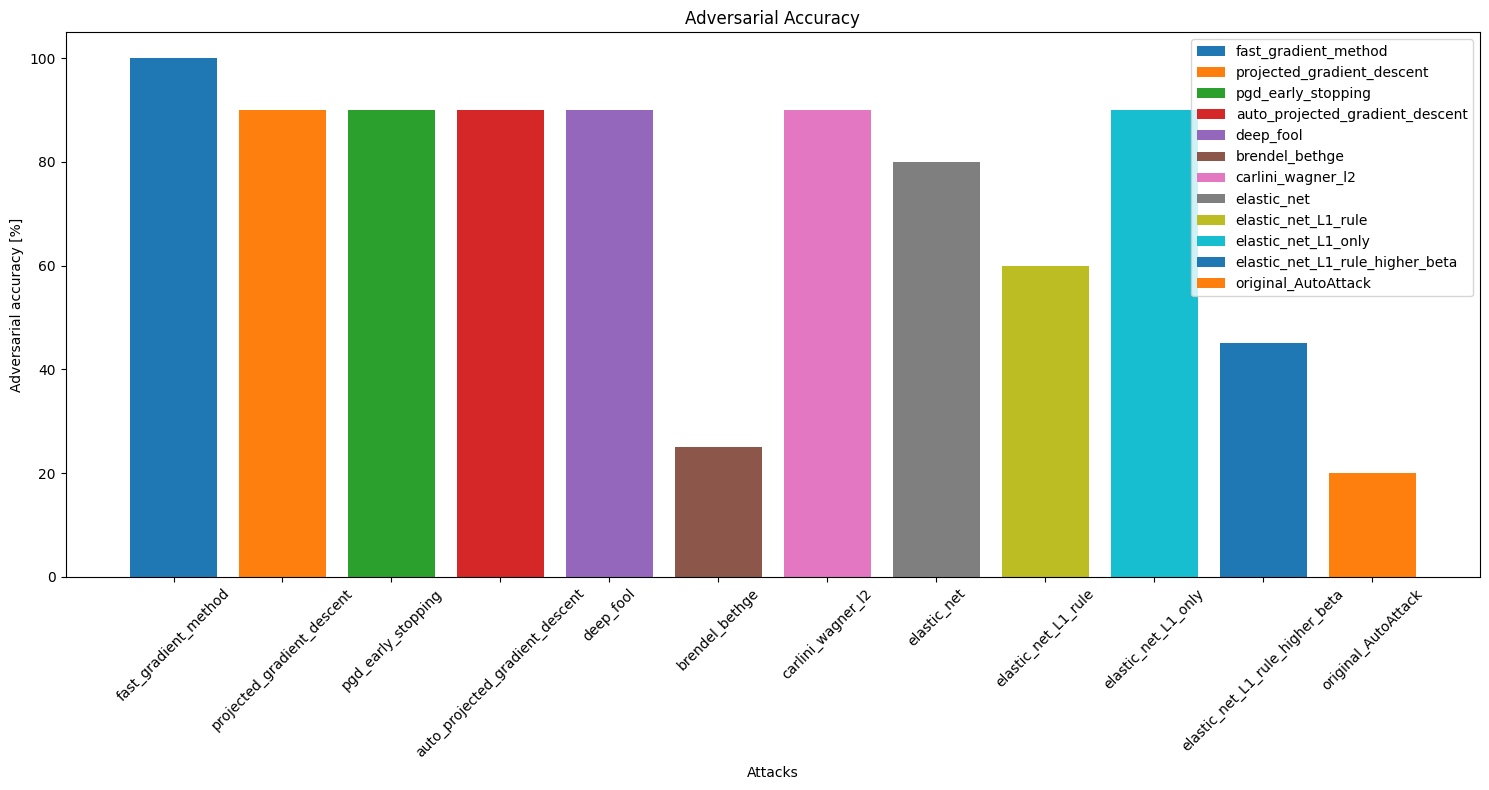

In [18]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['adversarial_accuracy'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Adversarial accuracy [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Adversarial Accuracy')
plt.tight_layout()
plt.show()

## Total Runtime

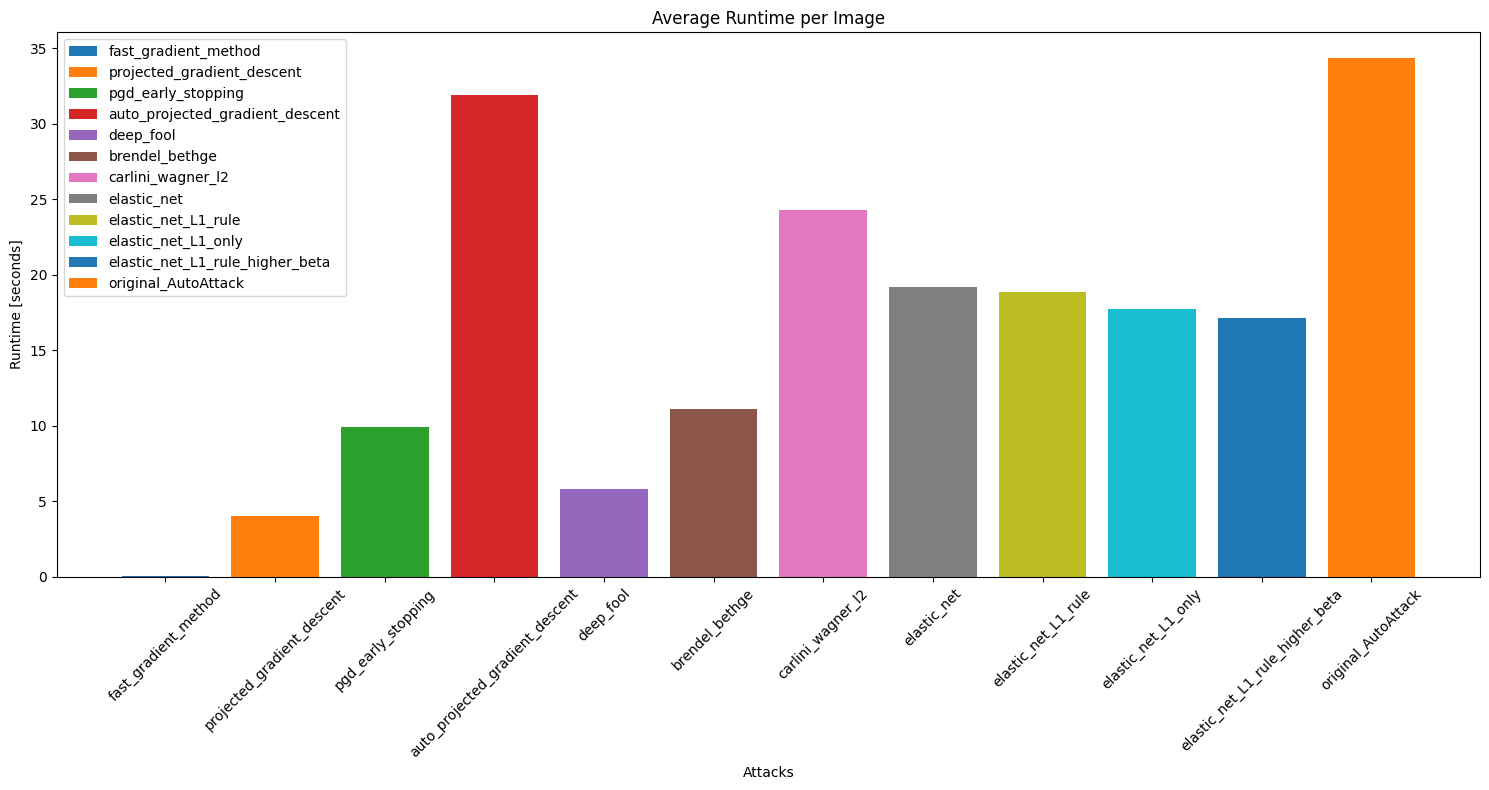

In [19]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, sum(results_dict[attack_type]['runtime'])/splitsize, label=attack_type)
plt.xlabel('Attacks')
plt.xticks(rotation=45)
plt.ylabel('Runtime [seconds]')
plt.title('Average Runtime per Image')
plt.legend()
plt.tight_layout()
plt.show()